In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import scipy as sp
import scipy.sparse as sps
from scipy.sparse import coo_matrix
import os
import matplotlib.pyplot as pyplot
%matplotlib inline 


## Evaluation or scoring?
eval = True

In [8]:
from RecLib.DataLoad import *
# Loading from CSV files...
UCM_age = toCoo('data_UCM_age.csv', 'user', 'age')
ICM_subclass = toCoo('data_ICM_sub_class.csv', 'item', 'subclass')
ICM_asset = toCoo('data_ICM_asset.csv', 'item', 'asset')
ICM_price = toCoo('data_ICM_price.csv', 'item', 'price')
UCM_region = toCoo('data_UCM_region.csv', 'user', 'region')
target_users = toNPArray('data_target_users_test.csv')
URM = toCoo('data_train.csv', 'user', 'item')

data_UCM_age.csv
user data, ID: min 2, max 30909, length 30317, unique 30317, repetitions 0, missig 1.91 %
age data, ID: min 1, max 10, length 30317, unique 10, repetitions 30307, missig 0.00 %

data_ICM_sub_class.csv
item data, ID: min 0, max 18494, length 18495, unique 18495, repetitions 0, missig 0.00 %
subclass data, ID: min 1, max 2010, length 18495, unique 1905, repetitions 16590, missig 5.18 %

data_ICM_asset.csv
item data, ID: min 0, max 18494, length 18490, unique 18490, repetitions 0, missig 0.02 %
asset data, ID: min 0, max 0, length 18490, unique 1, repetitions 18489, missig 0.00 %

data_ICM_price.csv
item data, ID: min 0, max 18494, length 18493, unique 18493, repetitions 0, missig 0.01 %
price data, ID: min 0, max 0, length 18493, unique 1, repetitions 18492, missig 0.00 %

data_UCM_region.csv
user data, ID: min 0, max 30910, length 26609, unique 26375, repetitions 234, missig 14.67 %
region data, ID: min 0, max 7, length 26609, unique 7, repetitions 26602, missig 0.00 %


In [9]:
URM = URM.tocsr()

In [10]:
## Split dataset (train % of .9999 gives similar performance on test set and competition set)
from Notebooks_utils.data_splitter import train_test_holdout
URM_train, URM_test = train_test_holdout(URM, train_perc = 0.8)


if not eval:
    URM_train = URM
else:
    from Base.Evaluation.Evaluator import EvaluatorHoldout
    evaluator_validation = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [11]:
## SLIM BPR Recommender - MAP 0.41 on test set
## set True if you want to train and compile SLIM BPR Recommender
if False:
    from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython 
    slim_rec = SLIM_BPR_Cython(URM_train, recompile_cython=False, verbose = False)
    MAP_LIST = []
    epochsList = [300]
    batchSize = [50]
    tklist = [10]
    lrs = [1e-3]

    for epochsN in epochsList:
        for bs in batchSize:
            for tk in tklist:
                for lr in lrs:
                    do_not_display_hystory = slim_rec.fit(epochs=epochsN, batch_size=bs, sgd_mode='adagrad', learning_rate=lr, topK = tk)
                    if eval:
                        dict_scores = (evaluator_validation.evaluateRecommender(slim_rec))[0][10]
                        MAP_LIST.append(('epoch, batch, topK, lr :' + str(epochsN) + ' ' + str(bs)+ ' ' + str(tk) + ' ' + str(lr), dict_scores['MAP']))
    if eval:
        print(MAP_LIST)

In [12]:
from RecLib.DataLoad import ICMbuilder 
ICM = ICMbuilder(URM_train, ICM_subclass, ICM_price, ICM_asset)
ICM = sps.csr_matrix(ICM)
ICM

[269 109  86 ... 173 156 207]
0 934 935 18490
0 1020 1021 18493


<18495x3967 sparse matrix of type '<class 'numpy.float64'>'
	with 55478 stored elements in Compressed Sparse Row format>

In [13]:
from RecLib.DataLoad import UCMbuilder 
UCM = UCMbuilder(URM_train, UCM_age, UCM_region)
UCM = sps.csr_matrix(UCM)
UCM

<30911x19 sparse matrix of type '<class 'numpy.float64'>'
	with 56926 stored elements in Compressed Sparse Row format>

In [14]:
if False:
    from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender 
    itemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM)
    MAP_LIST = []
    tklist = [3]
    shrinklist = [10]

    for tk in tklist:
        for sr in shrinklist:
            itemKNNCBF.fit(shrink=sr, topK = tk, similarity = 'cosine')
            if eval:
                dict_scores = (evaluator_validation.evaluateRecommender(itemKNNCBF))[0][10]
                MAP_LIST.append(('topK, shrink :' + str(tk) + ' ' + str(sr), dict_scores['MAP']))
    if eval:
        print(MAP_LIST)

In [32]:
if True:
    from KNN.UserKNNCBFRecommender import UserKNNCBFRecommender 
    userKNNCBF = UserKNNCBFRecommender(URM_train, UCM)
    MAP_LIST = []
    tklist = [2500]
    shrinklist = [10]

    for tk in tklist:
        for sr in shrinklist:
            userKNNCBF.fit(shrink=sr, topK = tk, similarity = 'cosine')
            if eval:
                dict_scores = (evaluator_validation.evaluateRecommender(userKNNCBF))[0][10]
                MAP_LIST.append(('topK, shrink :' + str(tk) + ' ' + str(sr), dict_scores['MAP']))
    if eval:
        print(MAP_LIST)
        

UserKNNCBFRecommender: URM Detected 4326 (14.00 %) cold users.
UserKNNCBFRecommender: URM Detected 3696 (19.98 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 19400 ( 63 % ), 645.71 column/sec, elapsed time 0.50 min
Similarity column 30911 ( 100 % ), 625.86 column/sec, elapsed time 0.82 min
EvaluatorHoldout: Processed 20416 ( 100.00% ) in 27.51 sec. Users per second: 742
[('topK, shrink :2500 10', 0.008825532392166316)]


In [41]:
if True:
    from KNN.UserKNNCFRecommender import UserKNNCFRecommender 
    userKNNCF = UserKNNCFRecommender(URM_train)
    MAP_LIST = []
    tklist = [600]
    shrinklist = [5]

    for tk in tklist:
        for sr in shrinklist:
            userKNNCF.fit(shrink=sr, topK = tk, similarity = 'cosine')
            if eval:
                dict_scores = (evaluator_validation.evaluateRecommender(userKNNCF))[0][10]
                MAP_LIST.append(('topK, shrink :' + str(tk) + ' ' + str(sr), dict_scores['MAP']))
    if eval:
        print(MAP_LIST)     

UserKNNCFRecommender: URM Detected 4326 (14.00 %) cold users.
UserKNNCFRecommender: URM Detected 3696 (19.98 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 25600 ( 83 % ), 850.91 column/sec, elapsed time 0.50 min
Similarity column 30911 ( 100 % ), 863.70 column/sec, elapsed time 0.60 min
EvaluatorHoldout: Processed 20416 ( 100.00% ) in 19.77 sec. Users per second: 1032
[('topK, shrink :600 5', 0.03691236805807318)]


In [40]:
## ItemCFKNNRecommender - MAP 0.47 on test set
# If you want to compile and train KNN set to True
if True:
    from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
    itemKNN = ItemKNNCFRecommender(URM_train)
    itemKNN.fit(shrink=50, topK=3)

    if eval:
        evaluator_validation = EvaluatorHoldout(URM_test, cutoff_list=[10])
        results, _ = evaluator_validation.evaluateRecommender(itemKNN)
        print('MAP: ' + str(results[10]["MAP"]))

ItemKNNCFRecommender: URM Detected 4326 (14.00 %) cold users.
ItemKNNCFRecommender: URM Detected 3696 (19.98 %) cold items.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 18495 ( 100 % ), 1153.45 column/sec, elapsed time 0.27 min
EvaluatorHoldout: Processed 20416 ( 100.00% ) in 14.11 sec. Users per second: 1447
MAP: 0.044962265971348635


In [34]:
## HYBRID: KNN + SLIM BPR
# Set to True if you want to compile and train this hybrid rec
from RecLib.HybridRecommender import *
if False: 
    hybridrecommender = HybridRecommender(URM_train, itemKNN, itemKNNCBF, slim_rec)
    hybridrecommender.fit(0.5, 0.1, 0.4)
    
    if eval:
        results, _ = evaluator_validation.evaluateRecommender(hybridrecommender)
        print('MAP: ' + str(results[10]["MAP"]))

In [35]:
if eval:
    for itr in range(300):
        to_compute_mask = np.ediff1d(URM_train.tocsr().indptr) == itr
        to_ignore_mask = np.invert(to_compute_mask)
        to_ignore = np.arange(URM_train.shape[0])[to_ignore_mask]
        if len(to_ignore) != URM_train.shape[0]:
            evaluator_validation = EvaluatorHoldout(URM_test, cutoff_list=[10], ignore_users = to_ignore)
            results, _ = evaluator_validation.evaluateRecommender(hybridrecommender)
            print('MAP at ' + str(itr) +' interactions: ' + str(results[10]["MAP"]))
        evaluator_validation = EvaluatorHoldout(URM_test, cutoff_list=[10])    

EvaluatorHoldout: Ignoring 26585 Users


NameError: name 'hybridrecommender' is not defined

PureSVDRecommender: URM Detected 4326 (14.00 %) cold users.
PureSVDRecommender: URM Detected 3696 (19.98 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!
TopPopRecommender: URM Detected 4326 (14.00 %) cold users.
TopPopRecommender: URM Detected 3696 (19.98 %) cold items.
Group 0, average p.len 0.00, min 0, max 0
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 242 ( 100.00% ) in 0.22 sec. Users per second: 1117
EvaluatorHoldout: Processed 242 ( 100.00% ) in 0.18 sec. Users per second: 1379
EvaluatorHoldout: Processed 242 ( 100.00% ) in 0.30 sec. Users per second: 802
EvaluatorHoldout: Processed 242 ( 100.00% ) in 0.19 sec. Users per second: 1249
EvaluatorHoldout: Processed 242 ( 100.00% ) in 0.19 sec. Users per second: 1265
Group 1, average p.len 0.00, min 0, max 0
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 213 ( 100.00% ) in 0.19 sec. Users per second: 1147
EvaluatorHold

EvaluatorHoldout: Processed 1510 ( 100.00% ) in 1.47 sec. Users per second: 1028
EvaluatorHoldout: Processed 1510 ( 100.00% ) in 1.99 sec. Users per second: 760
EvaluatorHoldout: Processed 1510 ( 100.00% ) in 1.40 sec. Users per second: 1076
EvaluatorHoldout: Processed 1510 ( 100.00% ) in 1.47 sec. Users per second: 1024
Group 17, average p.len 22.69, min 20, max 26
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 1541 ( 100.00% ) in 1.21 sec. Users per second: 1271
EvaluatorHoldout: Processed 1541 ( 100.00% ) in 1.59 sec. Users per second: 972
EvaluatorHoldout: Processed 1541 ( 100.00% ) in 2.45 sec. Users per second: 629
EvaluatorHoldout: Processed 1541 ( 100.00% ) in 1.88 sec. Users per second: 821
EvaluatorHoldout: Processed 1541 ( 100.00% ) in 1.54 sec. Users per second: 1003
Group 18, average p.len 30.15, min 26, max 36
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 1541 ( 100.00% ) in 1.37 sec. Users per second: 1122
EvaluatorHoldout: Proces

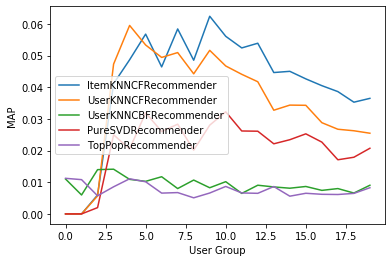

In [42]:
## TEST & VISUALIZE DIFFERENT RECSYS PERFORMANCE BASED ON N° OF INTERACTIONS HELD BY USERS
# Please, fill empty list with pretrained recommenders you want to compare

if eval:
    recommendersToCompare = [itemKNN, userKNNCF, userKNNCBF]
    from RecLib.PerUserGroupTesting import *
    compare(URM_train, URM_test, recommendersToCompare)

In [37]:
## Predict
## SET WHICH RECOMMENDER YOU WANNA USE
final_Rec = hybridrecommender
if not eval:
    output = []
    for user_id in target_users:
        output.append((user_id, final_Rec.recommend(user_id, cutoff=10)))

NameError: name 'hybridrecommender' is not defined

In [38]:
#Writedown results
if not eval:
    with open('submission.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["user_id", "item_list"])
        for row in output:
          ranking = ''
          for val in row[1]:
            ranking = ranking + str(val) + ' '
          writer.writerow([row[0], ranking[:-1]])